## Etapa 10 : Modelo Final 

Nesta etapa vamos treinar dois modelos, um com o dataset da rotulagem que fizemos, o outro vamos unir o dataset dos tweets rotulados com o dataset dos reviews do Google Store.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# importa funções para redes neurais
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, GRU

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')


In [2]:
def predicao(lista_texto):
    texto_token = tokenizer.texts_to_sequences(lista_texto)
    texto_padded_tokens = sequence.pad_sequences(texto_token, maxlen=250)
    return (model.predict(texto_padded_tokens[:len(lista_texto)]) > .5).astype(int)
    #return model.predict(texto_padded_tokens[:len(lista_texto)]).argmax(1)

def predicao_pesos(lista_texto):
    texto_token = tokenizer.texts_to_sequences(lista_texto)
    texto_padded_tokens = sequence.pad_sequences(texto_token, maxlen=250)
    return model.predict(texto_padded_tokens[:len(lista_texto)])

### Modelo 1 - Dataset Tweets Rotulados (Sem Nubank, Netflix e Ponto Frio)

In [3]:
#importa dataset
df = pd.read_csv('dataset_com_sentimento.csv', index_col=0)

In [4]:
df.head(5)

,in_reply_to_screen_name,full_text,sentimento,sentimento_CNN,sentimento_RNN,pesos_RNN,sentimento_medio
0,santander_br,isso qualquer operacao que eu tente fazer em ...,0,0,0,0.002110,0
1,santander_br,a atendente pagou pela segunda vez a fatura d...,0,1,0,0.199904,0
2,Bancointer,pode trazer o meus,1,1,1,0.998421,1
3,santander_br,nao estou conseguindo gerar cartao compra onl...,0,0,0,0.001986,0
4,itau,mas foi e o setup foi bem facil muito bom,1,1,1,0.997619,1


In [5]:
df.sentimento_medio.value_counts()

1    81235
0    41289
Name: sentimento_medio, dtype: int64

Como o dataset rotulado ficou desbalanceado, vamos remover alguns comentarios para que fique balanceado e sem viés para este modelo final.

In [6]:
# distribuição dos tweets negativos
df['in_reply_to_screen_name'][(df['sentimento_medio'] == 0)].value_counts()

NetflixBrasil      7200
nubank             4402
americanascom      4075
globoplay          3431
PrimeVideoBR       2703
Bradesco           2457
CasasBahia         1983
santander_br       1932
Bancointer         1838
submarino          1827
C6Bank             1574
pontofrio          1558
timeneon           1304
itau               1232
BancodoBrasil      1200
CocaCola_Br        1007
DisneyPlusBR        514
lojasamericanas     491
amazonBR            376
PepsiBr             174
brkindle             11
Name: in_reply_to_screen_name, dtype: int64

In [7]:
# distribuição dos tweets positivos
df['in_reply_to_screen_name'][(df['sentimento_medio'] == 1)].value_counts()

NetflixBrasil      31338
PrimeVideoBR       11319
globoplay           7685
submarino           5362
nubank              3835
pontofrio           3604
CocaCola_Br         3324
americanascom       2412
CasasBahia          2124
DisneyPlusBR        1905
Bancointer          1678
Bradesco            1280
C6Bank              1019
BancodoBrasil        996
santander_br         856
PepsiBr              852
itau                 782
timeneon             499
amazonBR             241
lojasamericanas       85
brkindle              39
Name: in_reply_to_screen_name, dtype: int64

Como existem muitos tweets de uma mesma empresa, vamos balancear para que todas as empresas fiquem com um tamanho de comentarios semelhante.

In [8]:
# removendo comentarios negativos
df.drop(df[(df['in_reply_to_screen_name'] == 'americanascom')
       & (df['sentimento_medio'] == 0)][:1600].index, inplace=True)

df.drop(df[(df['in_reply_to_screen_name'] == 'Bradesco')
       & (df['sentimento_medio'] == 0)][:1200].index, inplace=True)

In [9]:
# removendo comentarios positivos
df.drop(df[(df['in_reply_to_screen_name'] == 'NetflixBrasil')
       & (df['sentimento_medio'] == 1)][:25000].index, inplace=True)

df.drop(df[(df['in_reply_to_screen_name'] == 'PrimeVideoBR')
       & (df['sentimento_medio'] == 1)][:8500].index, inplace=True)

df.drop(df[(df['in_reply_to_screen_name'] == 'globoplay')
       & (df['sentimento_medio'] == 1)][:3000].index, inplace=True)

df.drop(df[(df['in_reply_to_screen_name'] == 'submarino')
       & (df['sentimento_medio'] == 1)][:3500].index, inplace=True)

df.drop(df[(df['in_reply_to_screen_name'] == 'CocaCola_Br')
       & (df['sentimento_medio'] == 1)][:2300].index, inplace=True)

df.drop(df[(df['in_reply_to_screen_name'] == 'DisneyPlusBR')
       & (df['sentimento_medio'] == 1)][:1400].index, inplace=True)

Por fim, vamos remover os tweets das empresas, Netflix, Nubank e Ponto Frio, e assim validarmos nosso modelo, simulando uma situação real de uma nova empresa interessada em descobrir o que estão falando dela.

In [10]:
# dropando netflix, nubank e ponto frio
df.drop(df[(df['in_reply_to_screen_name'] == 'NetflixBrasil')].index, inplace=True)
df.drop(df[(df['in_reply_to_screen_name'] == 'nubank')].index, inplace=True)
df.drop(df[(df['in_reply_to_screen_name'] == 'pontofrio')].index, inplace=True)

In [11]:
#verificando se o dataset ficou equilibrado
df.sentimento_medio.value_counts()

0    25329
1    23758
Name: sentimento_medio, dtype: int64

In [12]:
# separa dados em treino, teste e validação
train, test, _, _ = train_test_split(df, df['full_text'], test_size=0.2, random_state=42)

In [13]:
len(df), len(train), len(test)

(49087, 39269, 9818)

In [14]:
X = df['full_text'].values.astype(str)
X_train = train['full_text'].values.astype(str)
X_test = test['full_text'].values.astype(str)
y_train = train['sentimento_medio']
y_test = test['sentimento_medio']

<AxesSubplot:>

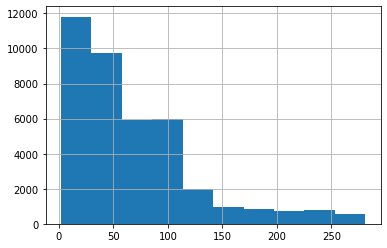

In [15]:
train['full_text'].apply(len).hist()

In [16]:
max_features = 33000
maxlen = 250

In [17]:
# treina um tokenizador nos dados de treino
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X)
len(tokenizer.word_index)

24090

In [18]:
# tokeniza os dados
X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)

In [19]:
# corta ou adiciona zeros em sequências maiores de 250
X_train_padded = sequence.pad_sequences(X_train_token, maxlen=maxlen)
X_test_padded = sequence.pad_sequences(X_test_token, maxlen=maxlen)
X_train_padded.shape, X_test_padded.shape

((39269, 250), (9818, 250))

In [20]:
y_train = np.asarray(y_train).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

In [22]:
# monta o modelo de rede neural
model = Sequential()
model.add(Embedding(max_features, 128, input_length=maxlen))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [23]:
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 128)          4224000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 250, 64)           41216     
_________________________________________________________________
dropout_2 (Dropout)          (None, 250, 64)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                24832     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 4,290,113
Trainable params: 4,290,113
Non-trainable params: 0
____________________________________________

In [109]:
# treina a rede neural
model.fit(x=X_train_padded, y=y_train, batch_size=256, epochs=5)

Epoch 1/5
154/154 [==============================] - 662s 4s/step - loss: 0.4696 - accuracy: 0.7700
Epoch 2/5
154/154 [==============================] - 720s 5s/step - loss: 0.2313 - accuracy: 0.9079
Epoch 3/5
154/154 [==============================] - 729s 5s/step - loss: 0.1556 - accuracy: 0.9404
Epoch 4/5
154/154 [==============================] - 752s 5s/step - loss: 0.1178 - accuracy: 0.9567
Epoch 5/5
154/154 [==============================] - 746s 5s/step - loss: 0.0934 - accuracy: 0.9666


In [110]:
#comparar os resultados
acc = model.evaluate(x=X_test_padded, y=y_test)

307/307 [==============================] - 26s 84ms/step - loss: 0.3369 - accuracy: 0.8890


In [111]:
# serialize model to JSON
model_json = model.to_json()
with open("model_final_M1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_final_M1.h5")
print("Modelo salvo em disco!")

Modelo salvo em disco!


### Modelo 2 - Dataset Tweets Rotulados (Sem Nubank, Netflix e Ponto Frio) + Reviwes Google Store

In [25]:
#importa dataset
df2 = pd.read_csv('reviews_geral_limpo.csv', index_col=0)

In [26]:
df2.head()

,content,score
0,gente mudem pro design anterior a interface ta...,1
1,gosto muito desse banco mas farei uma critica ...,1
2,ate agora estou gostando realmente essa nova i...,1
3,adoro esse ap raramente apresenta alguma falha...,1
4,simplesmente maravilhoso eu nunca vi um banco ...,1


Como os datasets tem um formato diferente entre eles, precisamos padroniza-los antes de uni-los.

In [27]:
# dataset reviews google store
# renomeando as colunas
df2.rename(columns={'content': 'full_text','score': 'sentimento'}, inplace = True)

# criando nova coluna
df2['in_reply_to_screen_name'] = 'Google Store'

# reordenando as colunas
df2 = df2.reindex(columns=['in_reply_to_screen_name','full_text','sentimento'])

In [28]:
# dataset tweets rotulados
# cortando colunas desnecessárias
#df = df[['in_reply_to_screen_name','full_text','sentimento']]
df = df[['in_reply_to_screen_name','full_text','sentimento_medio']]

# renomeando a coluna
df.rename(columns={'sentimento_medio': 'sentimento'}, inplace = True)	

In [29]:
# unindo os datasets
df_geral = pd.concat([df, df2], ignore_index=True)

In [30]:
# verificando o balanceamento
df_geral.sentimento.value_counts()

0    144582
1    141462
Name: sentimento, dtype: int64

In [31]:
df_geral.head(20)

,in_reply_to_screen_name,full_text,sentimento
0,santander_br,isso qualquer operacao que eu tente fazer em ...,0
1,santander_br,a atendente pagou pela segunda vez a fatura d...,0
2,Bancointer,pode trazer o meus,1
3,santander_br,nao estou conseguindo gerar cartao compra onl...,0
4,itau,mas foi e o setup foi bem facil muito bom,1
5,lojasamericanas,cara e inadmissivel o que minha esposa passou...,0
6,lojasamericanas,poderia me ajudar nao consigo encontrar os te...,0
7,lojasamericanas,esta dizendo que nao posso enviar mensagem pa...,0
8,lojasamericanas,mas eu estou seguindo,1
9,santander_br,ola gente bom dia quero entra na minha conta ...,1


In [32]:
# separa dados em treino, teste e validação
train, test, _, _ = train_test_split(df_geral, df_geral['full_text'], test_size=0.2, random_state=42)

In [33]:
len(df_geral), len(train), len(test)

(286044, 228835, 57209)

In [34]:
X = df_geral['full_text'].values.astype(str)
X_train = train['full_text'].values.astype(str)
X_test = test['full_text'].values.astype(str)
y_train = train['sentimento']
y_test = test['sentimento']

In [35]:
# treina um tokenizador nos dados de treino
tokenizer = Tokenizer(num_words=61000)
tokenizer.fit_on_texts(X)
len(tokenizer.word_index)

61149

In [36]:
# tokeniza os dados
X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)

In [37]:
# corta ou adiciona zeros em sequências maiores de 250
X_train_padded = sequence.pad_sequences(X_train_token, maxlen=maxlen)
X_test_padded = sequence.pad_sequences(X_test_token, maxlen=maxlen)
X_train_padded.shape, X_test_padded.shape

((228835, 250), (57209, 250))

In [38]:
y_train = np.asarray(y_train).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

In [39]:
# monta o modelo de rede neural
model = Sequential()
model.add(Embedding(61000, 128, input_length=maxlen))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [40]:
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 128)          7808000   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 250, 64)           41216     
_________________________________________________________________
dropout_4 (Dropout)          (None, 250, 64)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                24832     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 7,874,113
Trainable params: 7,874,113
Non-trainable params: 0
____________________________________________

In [183]:
# treina a rede neural
model.fit(x=X_train_padded, y=y_train, batch_size=256, epochs=5)

Epoch 1/5
894/894 [==============================] - 5236s 6s/step - loss: 0.2092 - accuracy: 0.9199
Epoch 2/5
894/894 [==============================] - 5279s 6s/step - loss: 0.1330 - accuracy: 0.9537
Epoch 3/5
894/894 [==============================] - 5387s 6s/step - loss: 0.1089 - accuracy: 0.9633
Epoch 4/5
894/894 [==============================] - 5377s 6s/step - loss: 0.0940 - accuracy: 0.9691
Epoch 5/5
894/894 [==============================] - 5385s 6s/step - loss: 0.0820 - accuracy: 0.9734


In [184]:
#comparar os resultados
acc = model.evaluate(x=X_test_padded, y=y_test)

1788/1788 [==============================] - 160s 90ms/step - loss: 0.1880 - accuracy: 0.9407


In [185]:
# serialize model to JSON
model_json = model.to_json()
with open("model_final_M2_SM.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_final_M2_SM.h5")
print("Modelo salvo em disco!")

Modelo salvo em disco!


In [112]:
# Exportando o dataset Unificado para um CSV
df_geral.to_csv('dataset_unificado.csv')